# 从0开始搭建机器学习训练框架

reader -> network -> trainer


- 制作训练数据集
- 写一个Reader
- 定义网络结构
- 定义Loss
- 定义权重更新策略

然后主要的训练框架如下

```python
for i in epochs:
    data, label in DataIter():
        with autograd.record():
            y = net(x)
            loss = loss(y, y_hat)
        loss.backward()
        update_params()
```

通过这一节收获到的技能是：

- 了解如何在Python里定义一个Iteration，来生成数据集
- 清楚了机器学习训练的一般流程和部件

In [1]:
from mxnet import ndarray as nd
from mxnet import autograd

# 创建数据集

In [2]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

X = nd.random.normal(shape=(1000,2))
y = X[:,0] * true_w[0] + X[:, 1] * true_w[1] + true_b;
y_hat = y + 0.01 * nd.random_normal(0,1, shape=y.shape)

# 数据可视化

In [3]:
import matplotlib.pyplot as plt

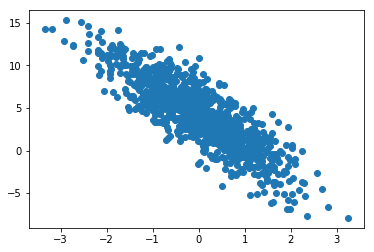

In [4]:
plt.scatter(X[:,1].asnumpy(), y.asnumpy())
plt.show()

# 定义Reader

In [5]:
import random
batch_size = 10
def data_iter(X, y, doshuffle=True):
    # 产生一个随机索引
    idx = list(range(num_examples))
    if doshuffle:
        random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size,num_examples)])
        yield nd.take(X, j), nd.take(y, j)

In [6]:
for data, label in data_iter(X, y_hat):
    print(data, label)
    break


[[-1.17618942  1.02423871]
 [ 0.83432126 -0.30592811]
 [-1.88524187 -0.84348118]
 [-0.68789554 -0.89566213]
 [-0.29877052  1.64374375]
 [-0.8813321   0.94868982]
 [ 0.65387917 -0.94953394]
 [-0.26636696  0.71143317]
 [ 2.14899468 -0.64691925]
 [ 0.49555334  0.16332558]]
<NDArray 10x2 @cpu(0)> 
[ -1.62617755   6.91625595   3.2915144    5.87868214  -1.97098565
  -0.79151291   8.74401665   1.24705625  10.68881798   4.63490772]
<NDArray 10 @cpu(0)>


# 定义模型

In [7]:
def net(x, params):
    return nd.dot(x, params[0]) + params[1]

# 定义loss

In [8]:
def square_loss(y, y_hat):
    return nd.sum(nd.square(y.reshape(y_hat.shape) - y_hat))

#  初始化参数及训练

epoch = 0, loss = 1.0242459716796875
epoch = 1, loss = 9.492580592632294e-05
epoch = 2, loss = 9.564822912216187e-05
epoch = 3, loss = 9.59952250123024e-05
epoch = 4, loss = 9.609189629554749e-05
epoch = 5, loss = 9.590161591768265e-05
epoch = 6, loss = 9.540844708681106e-05
epoch = 7, loss = 9.558574110269546e-05
epoch = 8, loss = 9.526292979717255e-05
epoch = 9, loss = 9.454186260700225e-05


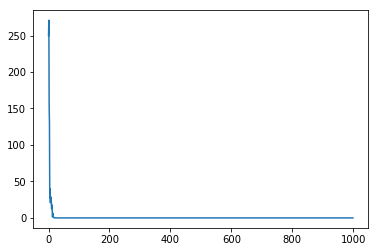

In [9]:
w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))
params = [w, b]
for param in params:
    param.attach_grad()
    
    
def SGD(params, lr):
    for param in params:
        param -= lr * param.grad

epoch = 10
learning_rate = 0.01

iter_loss=[]
for i in range(epoch):
    totle_loss = 0
    for data, label in data_iter(X, y_hat):
        with autograd.record():
            y = net(data, params)
            loss = square_loss(y, label)
        totle_loss += loss
        iter_loss.append(loss.asscalar())
        loss.backward()
        SGD(params, learning_rate)
    print('epoch = {}, loss = {}'.format(i, totle_loss.asscalar() / num_examples))

plt.plot(iter_loss)
plt.show()

In [10]:
print('trained params w = {}, the true w = {}'.format(params[0].asnumpy(), true_w))
print('trained params b = {}, the true b = {}'.format(params[1].asnumpy(), true_b))

trained params w = [[ 1.99962962]
 [-3.40039372]], the true w = [2, -3.4]
trained params b = [ 4.19955158], the true b = 4.2


# 使用GluonAPI

- 了解gluon.data模块
- 了解gluon.nn.Sequential模块
- 了解gluon.loss模块
- 了解gluon.Trainer模块

[Gluon API Reference](https://github.com/gluon-api/gluon-api)

In [11]:
from mxnet import gluon
batch_size = 10
# Step 1： 定义Reader
dataset = gluon.data.ArrayDataset(X, y_hat)
data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)
# Step 2: 定义模型
net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))
net.initialize() # 初始化模型的参数 
# Step3: 定义损失函数
square_loss = gluon.loss.L2Loss()
# Step4: 定义Trainer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.1})

epoch = 0, loss = 0.8937698758317274
epoch = 1, loss = 4.6691692390595566e-05
epoch = 2, loss = 4.671812310698442e-05
epoch = 3, loss = 4.605487792287022e-05
epoch = 4, loss = 4.640179446869297e-05
epoch = 5, loss = 4.634672907559434e-05
epoch = 6, loss = 4.692029506259132e-05
epoch = 7, loss = 4.6679022008902396e-05
epoch = 8, loss = 4.6538609101844484e-05
epoch = 9, loss = 4.6501884018653074e-05


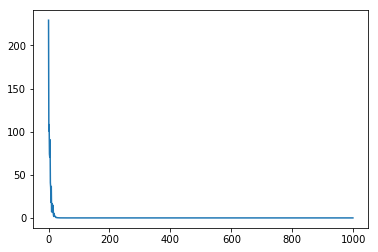

In [12]:
epoch = 10
iter_loss=[]
for i in range(epoch):
    total_loss = 0
    for data, label in data_iter:
        with autograd.record():
            y = net(data)
            loss = square_loss(y, label)
        total_loss += nd.sum(loss).asscalar()
        iter_loss.append(nd.sum(loss).asscalar())
        loss.backward()
        trainer.step(batch_size)
    print('epoch = {}, loss = {}'.format(i, total_loss / num_examples))

plt.plot(iter_loss)
plt.show()

In [13]:
dense = net[0]
true_w, dense.weight.data()

([2, -3.4], 
 [[ 2.00030875 -3.39994693]]
 <NDArray 1x2 @cpu(0)>)

In [14]:
true_b, dense.bias.data()

(4.2, 
 [ 4.20047712]
 <NDArray 1 @cpu(0)>)